## Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk.corpus
import os

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import simcube
from simcube.data import \
    tokenize_text_simple_regex, \
    tokenize_corpus, \
    build_vocabulary, \
    vectorize_texts, \
    SparseFeaturesDataset
from simcube.pipeline import \
    train_eval_loop, \
    predict_with_model, \
    init_random_seed
import logging
from pprint import pprint

In [3]:
init_random_seed()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
plt.rcParams["figure.figsize"] = (15,10)

## Предобработка текстов и подготовка признаков

In [4]:
from sklearn.datasets import load_files

In [5]:
target_dir = "../../data/raw/20news_home/"
train_source = load_files(os.path.join(target_dir, "20news-bydate-train"), encoding='latin1')
test_source = load_files(os.path.join(target_dir, "20news-bydate-test"), encoding='latin1')

In [6]:
print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.

Метка 9


## Подготовка признаков

In [7]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from cubbie garnet berkeley subject cubs behind marlins article agate 1pt592 organization university california berkeley lines nntp posting host garnet berkeley gajarsky pilot njin writes morgan guzman will have higher than last year cubs will idiots pitch harkey much hibbard castillo good think stud pitcher this season morgan guzman helped lead cubs even better than rotation atlanta cubs while braves know early season cubs fans have learned enjoy short triumph while still there


In [8]:
train_tokenized[0]

['from',
 'cubbie',
 'garnet',
 'berkeley',
 'subject',
 'cubs',
 'behind',
 'marlins',
 'article',
 'agate',
 '1pt592',
 'organization',
 'university',
 'california',
 'berkeley',
 'lines',
 'nntp',
 'posting',
 'host',
 'garnet',
 'berkeley',
 'gajarsky',
 'pilot',
 'njin',
 'writes',
 'morgan',
 'guzman',
 'will',
 'have',
 'higher',
 'than',
 'last',
 'year',
 'cubs',
 'will',
 'idiots',
 'pitch',
 'harkey',
 'much',
 'hibbard',
 'castillo',
 'good',
 'think',
 'stud',
 'pitcher',
 'this',
 'season',
 'morgan',
 'guzman',
 'helped',
 'lead',
 'cubs',
 'even',
 'better',
 'than',
 'rotation',
 'atlanta',
 'cubs',
 'while',
 'braves',
 'know',
 'early',
 'season',
 'cubs',
 'fans',
 'have',
 'learned',
 'enjoy',
 'short',
 'triumph',
 'while',
 'still',
 'there']

In [9]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)

In [10]:
print('Количество уникальных токенов', UNIQUE_WORDS_N)
pprint(list(vocabulary.items())[:10])
pprint(list(vocabulary.items())[-10:])

Количество уникальных токенов 21628
[('that', 0),
 ('this', 1),
 ('have', 2),
 ('with', 3),
 ('writes', 4),
 ('article', 5),
 ('posting', 6),
 ('host', 7),
 ('nntp', 8),
 ('there', 9)]
[('ugle', 21618),
 ('envoy', 21619),
 ('revisit', 21620),
 ('vowed', 21621),
 ('gruesome', 21622),
 ('porter', 21623),
 ('tuberculosis', 21624),
 ('davy', 21625),
 ('displaced', 21626),
 ('clemente', 21627)]


In [13]:
word_doc_freq[:10]

array([0.7079724 , 0.6014672 , 0.5914796 , 0.5626657 , 0.5084851 ,
       0.46597135, 0.44953156, 0.4277886 , 0.42222026, 0.3997702 ],
      dtype=float32)

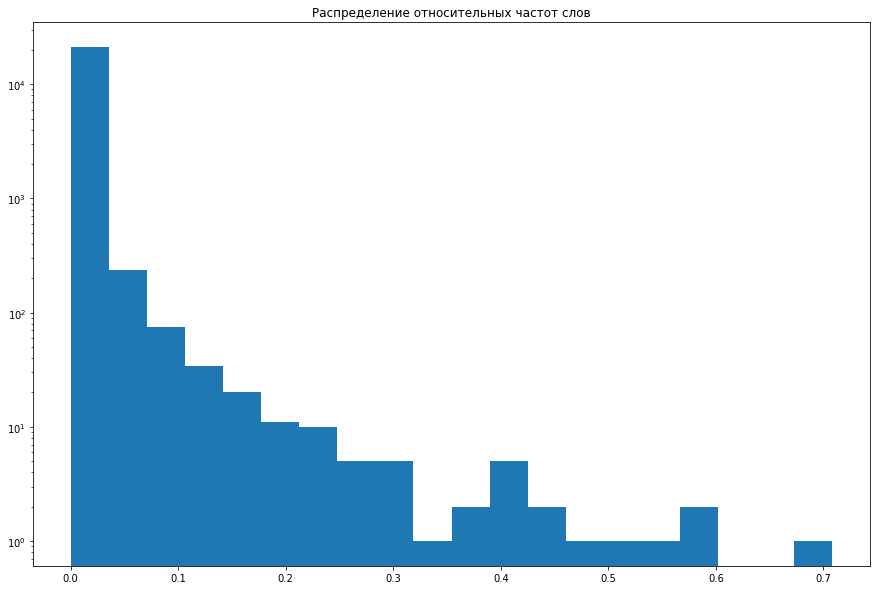

In [14]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [15]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (11314, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в обучающей выборке 721529
Процент заполненности матрицы признаков 0.44%


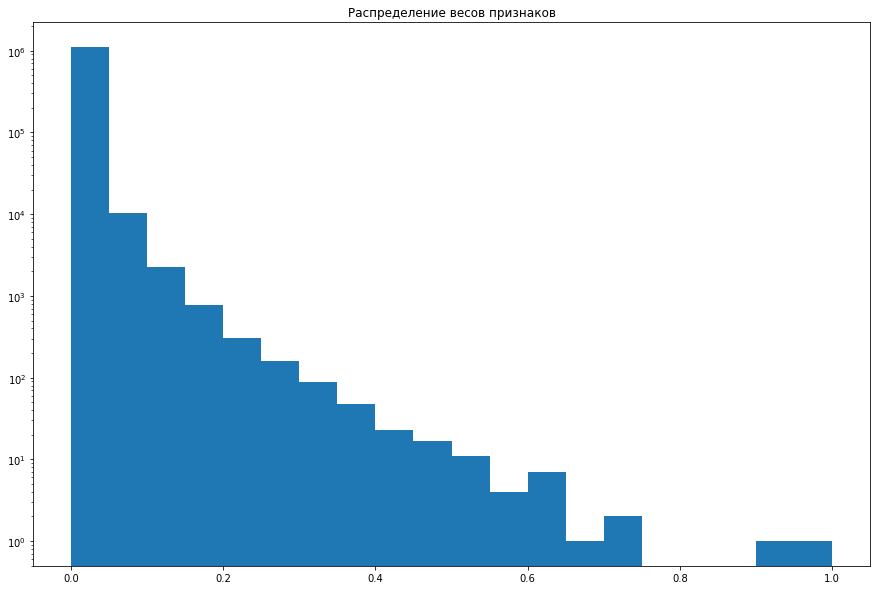

In [16]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

## Распределение классов

In [17]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


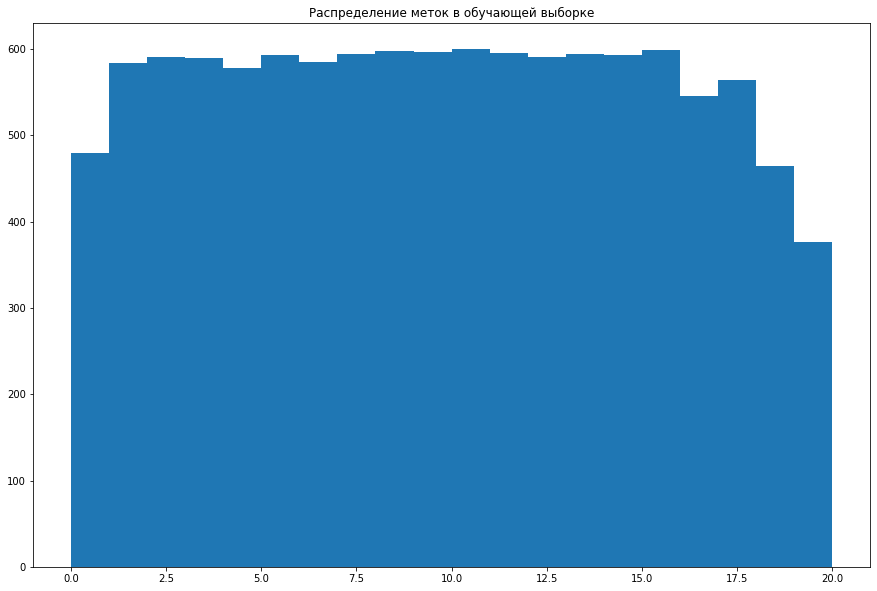

In [18]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

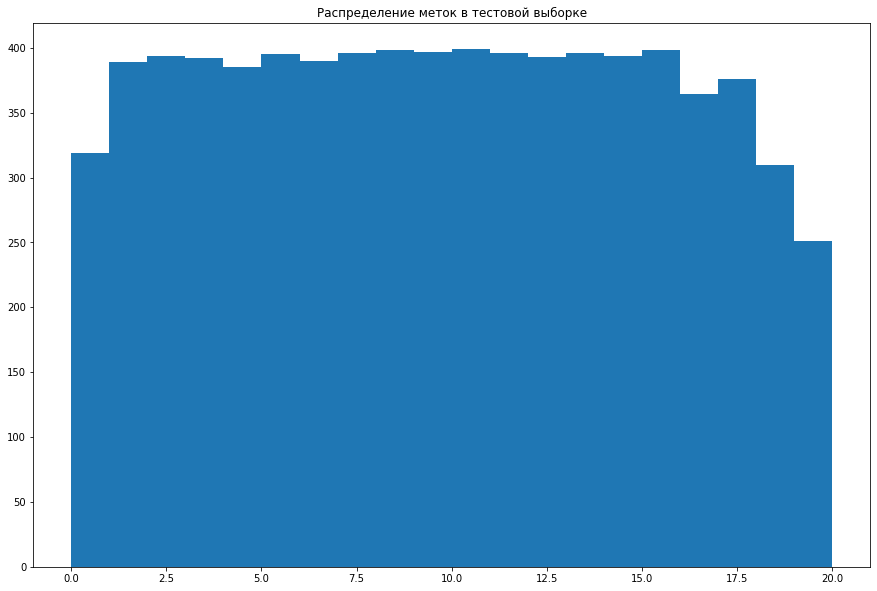

In [19]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

## PyTorch Dataset

In [20]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [27]:
UNIQUE_WORDS_N, UNIQUE_LABELS_N

(21628, 20)

In [28]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

# Эпоха 138
# Эпоха: 45 итераций, 1.97 сек
# Среднее значение функции потерь на обучении 0.00280743472588559
# Среднее значение функции потерь на валидации 0.9742347379525502
# Модель не улучшилась за последние 10 эпох, прекращаем обучение
# CPU times: user 7min 26s, sys: 1.67 s, total: 7min 27s
# Wall time: 7min 27s

# Среднее значение функции потерь на обучении 0.003090830286964774
# Доля верных ответов 0.9994696835778681                             
# Среднее значение функции потерь на валидации 0.9725616574287415
# Доля верных ответов 0.7586298459904408

In [29]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        MIDL_LAYER = 1000
        self.input = nn.Linear(UNIQUE_WORDS_N, MIDL_LAYER)
        self.output = nn.Linear(MIDL_LAYER, UNIQUE_LABELS_N)
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.output(self.input(x))
    
model = ManualLinearRegression()

# Эпоха 12
# Эпоха: 45 итераций, 2.61 сек
# Среднее значение функции потерь на обучении 0.006256493656352783
# Среднее значение функции потерь на валидации 1.8941650629043578
# Модель не улучшилась за последние 10 эпох, прекращаем обучение
# CPU times: user 52.9 s, sys: 725 ms, total: 53.6 s
# Wall time: 53.5 s
    
# Среднее значение функции потерь на обучении 0.10674776136875153
# Доля верных ответов 0.9854162983913736                           
# Среднее значение функции потерь на валидации 1.7581244707107544
# Доля верных ответов 0.6980881571959638   

In [34]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        MIDL_LAYER = 1000
        self.input = nn.Linear(UNIQUE_WORDS_N, MIDL_LAYER)
        self.drop_layer = nn.Dropout(p=0.3)
        self.output = nn.Linear(MIDL_LAYER, UNIQUE_LABELS_N)
        
    def forward(self, x):
        x = self.drop_layer(self.input(x))
        return self.output(x)
    
model = ManualLinearRegression()

# Эпоха 11
# Эпоха: 45 итераций, 2.64 сек
# Среднее значение функции потерь на обучении 0.1649884796804852
# Среднее значение функции потерь на валидации 14.34724661509196
# Модель не улучшилась за последние 10 эпох, прекращаем обучение
# CPU times: user 48.3 s, sys: 656 ms, total: 49 s
# Wall time: 48.9 s
    
# Среднее значение функции потерь на обучении 0.16051970422267914
# Доля верных ответов 0.9930175004419304                             
# Среднее значение функции потерь на валидации 4.858534336090088
# Доля верных ответов 0.6858736059479554   

In [36]:
%%time

scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, 
    patience=5, 
    factor=0.5, 
    verbose=True
)

best_val_loss, best_model = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=256,
    l2_reg_alpha=0,
    lr_scheduler_ctor=scheduler
)

Эпоха 0
Эпоха: 45 итераций, 2.69 сек
Среднее значение функции потерь на обучении 0.15894512861139246
Среднее значение функции потерь на валидации 4.90213159720103
Новая лучшая модель!

Эпоха 1
Эпоха: 45 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.38719557697574297
Среднее значение функции потерь на валидации 8.131339645385742

Эпоха 2
Эпоха: 45 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.4772060551577144
Среднее значение функции потерь на валидации 9.481128581364949

Эпоха 3
Эпоха: 45 итераций, 2.65 сек
Среднее значение функции потерь на обучении 0.7688176721334458
Среднее значение функции потерь на валидации 12.354978307088215

Эпоха 4
Эпоха: 45 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.6946823997630014
Среднее значение функции потерь на валидации 20.267900721232095

Эпоха 5
Эпоха: 45 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.8399546039394207
Среднее значение функции потерь на валидации 15.66856501

## Оценка качества

In [37]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 161.28it/s]
  7%|▋         | 16/235.375 [00:00<00:01, 159.55it/s]

Среднее значение функции потерь на обучении 0.16051970422267914
Доля верных ответов 0.9930175004419304



236it [00:01, 163.91it/s]                             


Среднее значение функции потерь на валидации 4.858534336090088
Доля верных ответов 0.6858736059479554


## Альтернативная реализация на scikit-learn

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [25]:
%%time

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

CPU times: user 4min 30s, sys: 4min 26s, total: 8min 56s
Wall time: 25.2 s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                 tokenizer=<function tokenize_text_simple_regex at 0x7f4580afd0d0>,
                                 use_idf=True, vocabulary=None)),
                ('cls',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fi

## Оценка качества

In [26]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.4954788918634194
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582384146
Доля верных ответов 0.8190387679235263
